# **Import Library dan Install Dependensi**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow -q

In [15]:
# Library untuk manipulasi data dan analisis numerik
import pandas as pd
import numpy as np

# Library untuk plotting dan visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk operasi sistem, manipulasi file dan direktori, serta handling file zip
import zipfile
import os
import shutil

# Library untuk augmentasi dan preprocessing gambar pada deep learning dengan Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Library untuk mengabaikan peringatan agar output lebih bersih
import warnings
warnings.filterwarnings('ignore')

# Library untuk progress bar saat iterasi panjang
from tqdm import tqdm

# Library untuk permodelan DL
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications import MobileNet

In [4]:
tf.__version__

'2.18.0'

# **Loading Dataset**

In [5]:
zip_path = './drive/MyDrive/Hijabist-Drive/Skin-tone/Hijabist-dataset/aug-st-hijabist.zip'
extract_path = './'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  print(f"Mengekstrak {zip_path} ke {extract_path}...")
  zip_ref.extractall(extract_path)
  print("Ekstraksi selesai.")

Mengekstrak ./drive/MyDrive/Hijabist-Drive/Skin-tone/Hijabist-dataset/aug-st-hijabist.zip ke ./...
Ekstraksi selesai.


In [6]:
# Direktori dataset
train_dir = "./dataset-skin-tone_split/train"
val_dir = "./dataset-skin-tone_split/val"

# **Data Generator Setup**

In [7]:
# Data generator untuk training
train_datagen = ImageDataGenerator(rescale=1./255)

# Data generator untuk validasi
val_datagen = ImageDataGenerator(rescale=1./255)

# Generator training
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224), # Ukuran input default ResNet50
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

# Generator validasi
val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 2800 images belonging to 4 classes.
Found 508 images belonging to 4 classes.


In [8]:
print(f"jumlah kelas :", len(train_generator.class_indices))
print(train_generator.class_indices)  # Mengecek jumlah kelas yang dikenali

jumlah kelas : 4
{'dark': 0, 'light': 1, 'mid-dark': 2, 'mid-light': 3}


# **Modelling**

In [26]:
# Menggunakan pretrained model sebagai base model, tanpa top
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Set semua layer agar bisa di-fine-tune
for layer in base_model.layers:
    layer.trainable = True

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Bangun model akhir
model = Model(inputs=base_model.input, outputs=output)

In [27]:
# Tampilkan arsitektur model
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,524,676 (13.45 MB)

 Trainable params: 3,502,788 (13.36 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [28]:
model.compile(
    optimizer=AdamW(learning_rate=0.0001, weight_decay=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('model_best.keras', save_best_only=True, monitor='val_loss', verbose=1)
]

In [30]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.4153 - loss: 1.6158
Epoch 1: val_loss improved from inf to 0.87385, saving model to model_best.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 48s 252ms/step - accuracy: 0.4164 - loss: 1.6117 - val_accuracy: 0.6024 - val_loss: 0.8739 - learning_rate: 1.0000e-04
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6894 - loss: 0.7318
Epoch 2: val_loss improved from 0.87385 to 0.44192, saving model to model_best.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.6897 - loss: 0.7315 - val_accuracy: 0.8307 - val_loss: 0.4419 - learning_rate: 1.0000e-04
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7780 - loss: 0.5538
Epoch 3: val_loss improved from 0.44192 to 0.28000, saving model to model_best.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.7780 - loss: 0.5538 - val_accuracy: 0.8898 - val_loss: 0.2800 - learning_rate: 1.0000e-04
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step 

In [22]:
labels = list(train_generator.class_indices.keys())
with open('labels.txt', 'w') as f:
  for item in labels:
    f.write("%s\n" % item)

# **Evaluasi**

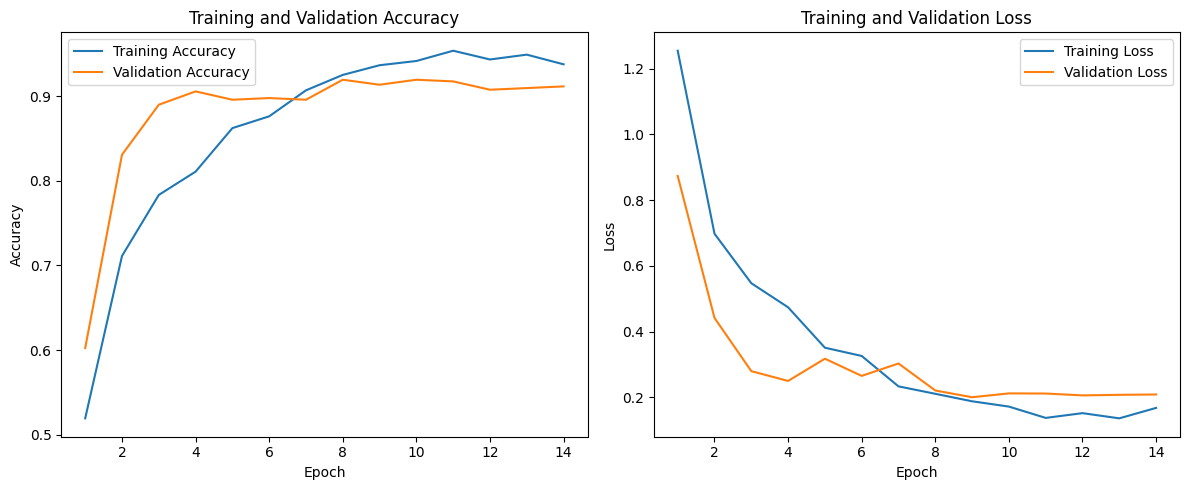

In [31]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Panggil fungsi ini setelah training
plot_training_history(history)

In [32]:
# Prediksi di data validasi
val_generator.reset()
pred_probs = model.predict(val_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# metrik evaluasi
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\n Evaluasi Model:")
print(f" - Accuracy : {acc:.4f}")
print(f" - Precision: {prec:.4f}")
print(f" - Recall   : {rec:.4f}")
print(f" - F1-Score : {f1:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step

 Evaluasi Model:
 - Accuracy : 0.9134
 - Precision: 0.9129
 - Recall   : 0.9147
 - F1-Score : 0.9135



 Classification Report:
              precision    recall  f1-score   support

        dark       0.90      0.94      0.92       108
       light       0.93      0.95      0.94       134
    mid-dark       0.91      0.88      0.89       130
   mid-light       0.91      0.89      0.90       136

    accuracy                           0.91       508
   macro avg       0.91      0.91      0.91       508
weighted avg       0.91      0.91      0.91       508



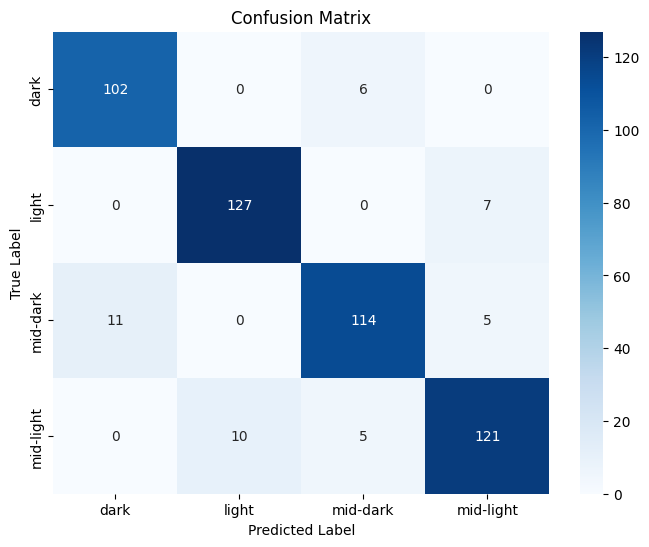

In [33]:
# Classification report
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **Inference**

In [34]:
# Library untuk Inference and Utility
import cv2
import dlib
from PIL import Image
from tensorflow.keras.models import load_model
from google.colab import files
import urllib.request
import bz2

In [35]:
url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
bz2_path = 'shape_predictor_68_face_landmarks.dat.bz2'
dat_path = 'shape_predictor_68_face_landmarks.dat'

# Download jika belum ada
if not os.path.exists(dat_path):
    print("Downloading predictor...")
    urllib.request.urlretrieve(url, bz2_path)

    print("Extracting predictor...")
    with bz2.BZ2File(bz2_path) as fr, open(dat_path, 'wb') as fw:
        fw.write(fr.read())

    os.remove(bz2_path)
    print("Done.")
else:
    print("Predictor file already exists.")

Extracting predictor...
Done.


In [36]:
# Inisialisasi detektor wajah dlib
# dlib akan digunakan untuk mendeteksi lokasi wajah.
try:
    detector = dlib.get_frontal_face_detector()
    print("Detektor dlib berhasil diinisialisasi.")
except Exception as e:
    print(f"Gagal menginisialisasi dlib face detector: {e}")
    detector = None # Set detector menjadi None jika gagal

# Muat model terbaik yang sudah dilatih
model_path_keras = '/content/model_best.keras'  # Path untuk model format Keras v3
model = None

if detector:
    try:
        model = tf.keras.models.load_model(model_path_keras)
        print(f"Model berhasil dimuat dari {model_path_keras}")
    except Exception as e_keras:
        print(f"Gagal memuat model dari {model_path_keras}: {e_keras}")
else:
    print("Detektor wajah tidak terinisialisasi, proses inferensi tidak dapat dilanjutkan tanpa deteksi wajah.")

Detektor dlib berhasil diinisialisasi.
Model berhasil dimuat dari /content/model_best.keras


In [37]:
# Mapping indeks kelas ke nama kelas dari file labels.txt
labels_file_path = '/content/labels.txt'
class_labels = []

with open(labels_file_path, 'r') as f:
    for line in f:
        class_labels.append(line.strip())

# Ukuran gambar yang digunakan untuk pelatihan model
target_size = (224, 224)

In [99]:
def preprocess_image(image_path, detector_dlib, predictor_path, target_size=(224, 224)):
    """
    Melakukan preprocessing lengkap pada satu gambar untuk inferensi:
    - CLAHE
    - Deteksi wajah
    - Cropping wajah berdasarkan landmark (rapat tapi tetap menyisakan dahi)
    - Resize tanpa padding ke target_size
    - Normalisasi (0–1)
    - Expand dims
    """
    try:
        predictor = dlib.shape_predictor(predictor_path)

        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Gambar tidak bisa dibaca dari {image_path}")
            return None

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_gray = clahe.apply(gray)

        faces = detector_dlib(enhanced_gray, 1)
        if not faces:
            print(f"Peringatan: Tidak ada wajah terdeteksi pada {os.path.basename(image_path)}")
            return None

        face = faces[0]
        landmarks = predictor(enhanced_gray, face)
        points = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(68)])

        # Bounding box awal dari landmark
        x1 = points[:, 0].min()
        x2 = points[:, 0].max()
        y1 = points[:, 1].min()
        y2 = points[:, 1].max()

        # Tambahkan margin
        margin_side = 5
        margin_bottom = 5

        # Estimasi margin atas berdasarkan hidung dan dagu
        chin_y = points[8][1]
        nose_y = points[27][1]
        vertical_face = chin_y - nose_y
        extra_forehead_margin = int(vertical_face * 0.4)

        x1 = max(0, x1 - margin_side)
        x2 = min(img.shape[1], x2 + margin_side)
        y1 = max(0, y1 - extra_forehead_margin)
        y2 = min(img.shape[0], y2 + margin_bottom)

        if x1 >= x2 or y1 >= y2:
            print(f"Peringatan: Ukuran cropping tidak valid pada {os.path.basename(image_path)}")
            return None

        cropped_img = img[y1:y2, x1:x2]
        if cropped_img.size == 0:
            print(f"Peringatan: Area cropping kosong untuk {os.path.basename(image_path)}")
            return None

        cropped_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(cropped_rgb)

        resample_method = Image.Resampling.LANCZOS if hasattr(Image, 'Resampling') else Image.LANCZOS
        resized = pil_img.resize(target_size, resample=resample_method)

        img_array = np.array(resized).astype('float32') / 255.0
        return np.expand_dims(img_array, axis=0)

    except Exception as e:
        print(f"Error saat memproses gambar {os.path.basename(image_path)}: {e}")
        return None


In [95]:
def predict_skin_tone(image_path, model_loaded, class_labels_list, detector_for_preprocess, predictor_path_for_preprocess, target_size=(224, 224)):
    """
    Memproses gambar baru, melakukan prediksi skin tone menggunakan model,
    dan menampilkan hasil prediksi beserta gambar asli & gambar yang telah diproses.
    """
    if model_loaded is None:
        print("Error: Model belum berhasil dimuat. Tidak bisa melakukan prediksi skin tone")
        return
    if detector_for_preprocess is None:
        print("Error: Detektor dlib tidak tersedia untuk preprocessing.")
        return
    if predictor_path_for_preprocess is None:
        print("Error: Path predictor dlib tidak tersedia untuk preprocessing.")
        return

    print(f"Memproses gambar untuk prediksi face shape: {os.path.basename(image_path)}...")

    # Simpan versi asli untuk ditampilkan nanti
    try:
        original_image_pil = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Gagal membuka gambar original: {e}")
        return

    # Preprocessing
    processed_image_batch = preprocess_image(
        image_path,
        detector_for_preprocess,
        predictor_path_for_preprocess,
        target_size
    )

    if processed_image_batch is None:
        print("Preprocessing gambar gagal. Tidak bisa melanjutkan prediksi skin tone.")
        # Tetap tampilkan gambar original sebagai referensi
        plt.figure(figsize=(5, 5))
        plt.imshow(original_image_pil)
        plt.title(f"Original Image (Preprocessing Gagal):\n{os.path.basename(image_path)}")
        plt.axis('off')
        plt.show()
        return

    # Prediksi
    print("Melakukan prediksi skin tone...")
    predictions_batch = model_loaded.predict(processed_image_batch)
    predictions_single = predictions_batch[0]
    predicted_class_index = np.argmax(predictions_single)

    if not class_labels_list or predicted_class_index >= len(class_labels_list):
        predicted_label = "Tidak Diketahui (Indeks Kelas Invalid)"
        print(f"Peringatan: Indeks kelas prediksi ({predicted_class_index}) di luar jangkauan class_labels_list ({len(class_labels_list)})")
    else:
        predicted_label = class_labels_list[predicted_class_index]

    print(f"Hasil Prediksi Face Shape: {predicted_label} (Probabilitas: {predictions_single[predicted_class_index]:.4f})")

    print("Probabilitas per kelas:")
    for i, prob in enumerate(predictions_single):
        label = class_labels_list[i] if i < len(class_labels_list) else f"Kelas_{i}"
        print(f"  - {label}: {prob:.4f}")

    # Tampilkan gambar original & processed side by side
    try:
        processed_img_display = (processed_image_batch[0] * 255).astype(np.uint8)

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Gambar asli
        axs[0].imshow(original_image_pil)
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        # Gambar yang diproses
        axs[1].imshow(processed_img_display)
        axs[1].set_title(f"Processed Image\nPrediction: {predicted_label}")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()
    except Exception as e_disp:
        print(f"Gagal menampilkan gambar: {e_disp}")

In [40]:
def upload_and_predict_colab(model_to_use, labels_list, detector_obj, predictor_path_obj, size_tuple=(224, 224)):
    """
    Meminta pengguna mengunggah satu atau beberapa gambar melalui antarmuka Colab,
    menyimpannya sementara, melakukan prediksi, lalu menghapusnya.
    """
    if model_to_use is None or detector_obj is None or predictor_path_obj is None:
        print("Model, Detektor dlib, atau Predictor dlib belum siap. Unggah dibatalkan.")
        return

    print("Silakan unggah gambar Anda (bisa lebih dari satu):")
    try:
        uploaded_files_dict = files.upload() # Menampilkan dialog upload Colab

        if not uploaded_files_dict:
            print("Tidak ada file yang diunggah.")
            return

        for file_name in uploaded_files_dict.keys():
            print(f'\nMemproses file unggahan: "{file_name}" ({len(uploaded_files_dict[file_name])} bytes)')

            # Simpan file yang diunggah ke _file system_ sementara Colab agar bisa dibaca path-nya
            temp_image_path = file_name
            with open(temp_image_path, 'wb') as f:
                f.write(uploaded_files_dict[file_name])

            # Lakukan prediksi pada gambar yang diunggah
            predict_skin_tone(temp_image_path, model_to_use, labels_list, detector_obj, predictor_path_obj, size_tuple)

            # Hapus file lokal setelah selesai diproses (opsional, untuk kebersihan)
            try:
                os.remove(temp_image_path)
                print(f"File sementara '{temp_image_path}' telah dihapus.")
            except Exception as e_remove:
                print(f"Gagal menghapus file sementara '{temp_image_path}': {e_remove}")
    except Exception as e_upload:
        print(f"Terjadi error saat proses unggah atau prediksi: {e_upload}")


 MEMULAI SESI UNGGAH DAN PREDIKSI GAMBAR BARU 
Silakan unggah gambar Anda (bisa lebih dari satu):


Saving mid-dark.jpeg to mid-dark.jpeg
Saving dark-skin.jpeg to dark-skin.jpeg
Saving mid-lighst.jpg to mid-lighst.jpg
Saving light-skin.webp to light-skin.webp

Memproses file unggahan: "mid-dark.jpeg" (26088 bytes)
Memproses gambar untuk prediksi face shape: mid-dark.jpeg...
Melakukan prediksi skin tone...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Hasil Prediksi Face Shape: mid-dark (Probabilitas: 0.9122)
Probabilitas per kelas:
  - dark: 0.0745
  - light: 0.0037
  - mid-dark: 0.9122
  - mid-light: 0.0096


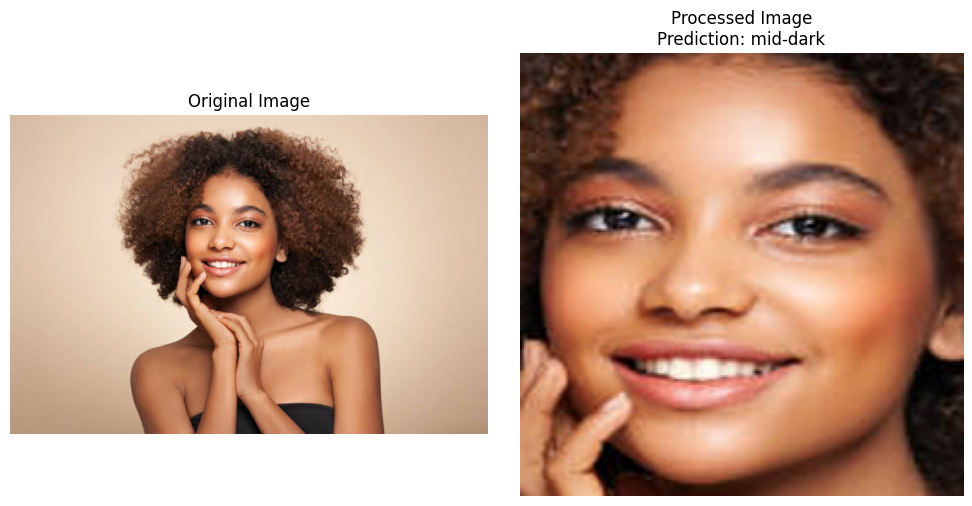

File sementara 'mid-dark.jpeg' telah dihapus.

Memproses file unggahan: "dark-skin.jpeg" (9570 bytes)
Memproses gambar untuk prediksi face shape: dark-skin.jpeg...
Melakukan prediksi skin tone...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Hasil Prediksi Face Shape: dark (Probabilitas: 0.5212)
Probabilitas per kelas:
  - dark: 0.5212
  - light: 0.0004
  - mid-dark: 0.4768
  - mid-light: 0.0016


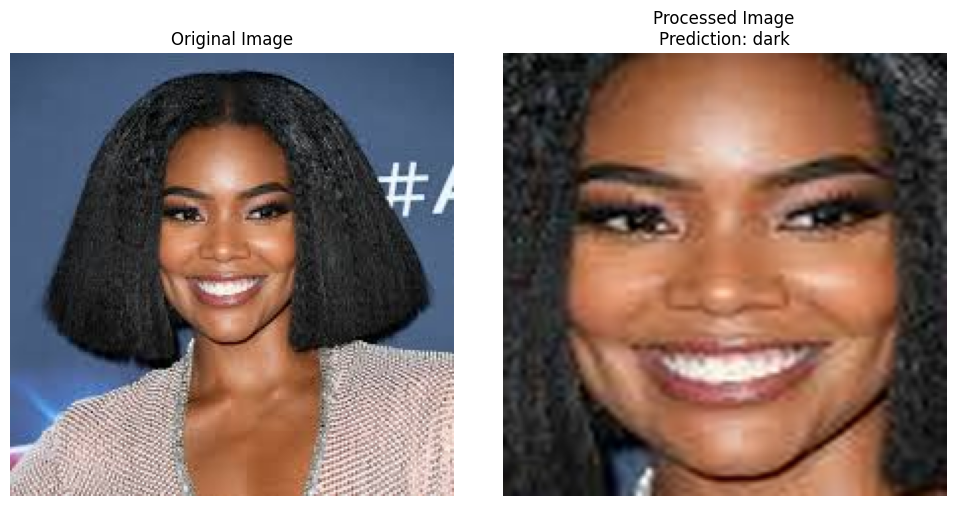

File sementara 'dark-skin.jpeg' telah dihapus.

Memproses file unggahan: "mid-lighst.jpg" (42927 bytes)
Memproses gambar untuk prediksi face shape: mid-lighst.jpg...
Melakukan prediksi skin tone...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Hasil Prediksi Face Shape: mid-light (Probabilitas: 0.9129)
Probabilitas per kelas:
  - dark: 0.0019
  - light: 0.0774
  - mid-dark: 0.0078
  - mid-light: 0.9129


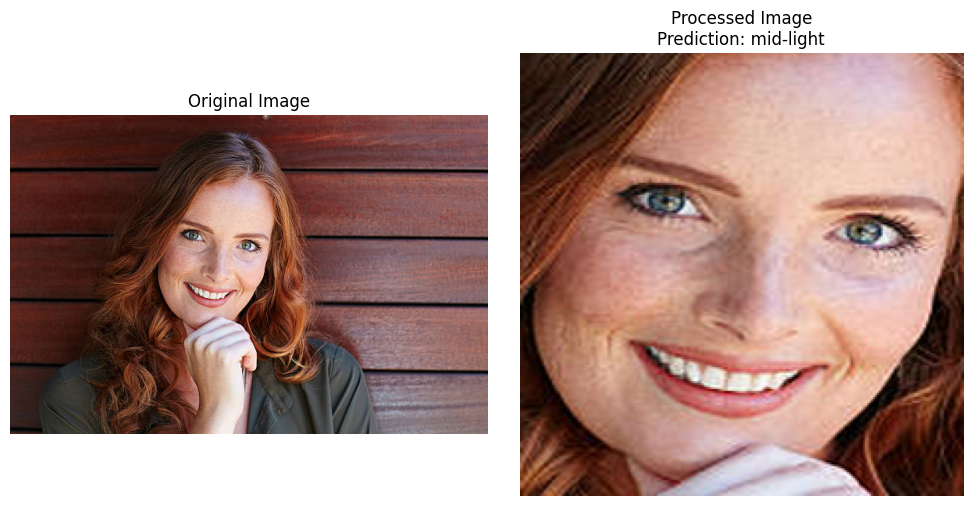

File sementara 'mid-lighst.jpg' telah dihapus.

Memproses file unggahan: "light-skin.webp" (138588 bytes)
Memproses gambar untuk prediksi face shape: light-skin.webp...
Melakukan prediksi skin tone...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Hasil Prediksi Face Shape: light (Probabilitas: 0.9977)
Probabilitas per kelas:
  - dark: 0.0000
  - light: 0.9977
  - mid-dark: 0.0001
  - mid-light: 0.0022


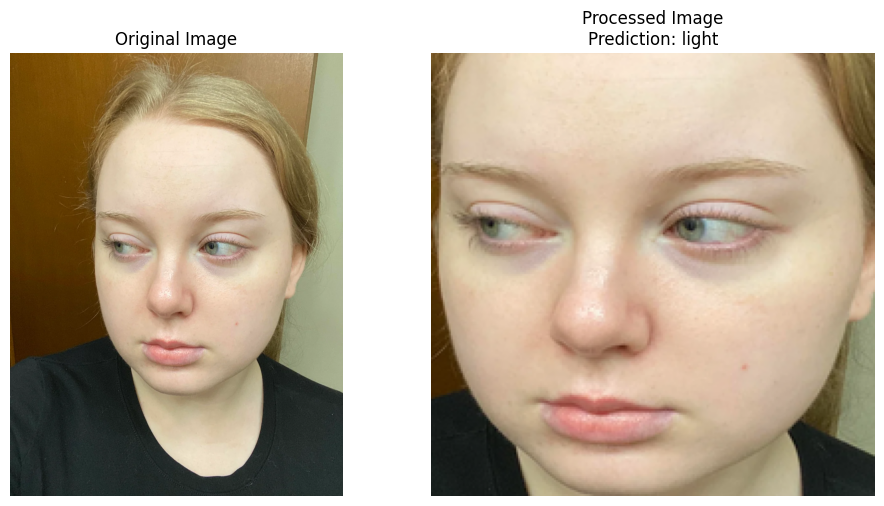

File sementara 'light-skin.webp' telah dihapus.


In [108]:
if model is not None and detector is not None:
    print("\n===================================================")
    print(" MEMULAI SESI UNGGAH DAN PREDIKSI GAMBAR BARU ")
    print("===================================================")

    # Path ke file shape_predictor_68_face_landmarks.dat
    predictor_path = 'shape_predictor_68_face_landmarks.dat'

    # Periksa apakah file predictor ada sebelum memanggil fungsi
    if os.path.exists(predictor_path):
        upload_and_predict_colab(model, class_labels, detector, predictor_path, target_size)
    else:
        print(f"\nError: File predictor '{predictor_path}' tidak ditemukan.")
        print("Tidak dapat melanjutkan. Pastikan predictor sudah diunduh dan diekstrak dengan benar.")

else:
    print("\nModel atau Detektor dlib tidak berhasil dimuat/diinisialisasi.")
    print("Tidak dapat melanjutkan ke proses unggah dan prediksi.")
    print("Silakan periksa pesan error pada bagian inisialisasi di atas.")